# Building an AI-Powered Sales Call Analyzer with LangChain

## Overview

This tutorial demonstrates how to build an AI-powered sales call analyzer using LangChain and CrewAI, robust frameworks for developing complex language model applications. The goal of this project is to transcribe audio from sales calls, analyze the transcription using natural language processing (NLP) techniques, and generate a detailed report on the call, including sentiment analysis, key phrases, pain points, and recommendations for improvement.

## Motivation

In sales environments, analyzing call transcriptions can provide valuable insights into customer behavior, agent performance, and opportunities for improvement. By automating the process of transcription and analysis, businesses can save time, enhance their training, and improve their customer interactions. This project combines OpenAI's Whisper for audio transcription and CrewAI's task automation to build an efficient, scalable solution for call analysis.

## Key Components

- **Audio Transcription**: Use OpenAI Whisper to transcribe audio calls into text.
- **Call Analysis**: Define tasks for analyzing the transcription using sentiment analysis, key phrase extraction, customer pain points, agent effectiveness, and more.
- **Task Automation**: Use CrewAI's agents and tasks framework to structure and automate the analysis process.
- **Report Generation**: Generate a detailed, structured report containing actionable insights for improving sales calls.

## Method Details
Adding necessary packages
### 1. **packages**: Adding necessary packages.

In [ ]:
!pip install langchain langchain-openai langchain-community crewai crewai-tools pydub ffmpeg-python onnxruntime requests

### 2. **Initialization**: Setting up the environment and importing necessary libraries.

We will begin by importing the required libraries

In [ ]:
#imports
from langchain_community.document_loaders.parsers import OpenAIWhisperParser
from langchain_core.documents.base import Blob
from dotenv import load_dotenv
from textwrap import dedent
from crewai import Task, Agent, Crew
from langchain_openai import ChatOpenAI
import asyncio

Next, we will be loading environment variables (OpenAI API key)

In [ ]:
load_dotenv()

### 3. **Audio Transcription**: Transcribing sales call audio using OpenAI Whisper.

We will use OpenAI Whisper to transcribe audio files into text. The `transcribe_audio` function takes the path to an audio file, processes it, and returns the transcribed text.

In [ ]:
# Initialize the Whisper parser
parser = OpenAIWhisperParser()

# Function to transcribe audio using OpenAI Whisper
def transcribe_audio(audio_path: str) -> str:
    """
    Transcribe audio from a given file path using OpenAI Whisper.

    Args:
        audio_path (str): The path to the audio file to be transcribed.

    Returns:
        str: The transcribed text from the audio.
    """
    try:
        # Initialize the Blob with the given audio path
        audio_blob = Blob(path=audio_path)

        # Transcribe the audio
        documents = parser.lazy_parse(blob=audio_blob)

        # Collect and return the transcription as a single string
        transcription = ""
        for doc in documents:
            transcription += doc.page_content

        return transcription

    except Exception as e:
        print(f"Error during transcription: {e}")
        return ""

### 4. **Call Analysis**: Defining the tasks for analyzing the transcription.

Next, we'll define a task that structures the analysis of a sales call. This task includes sentiment analysis, key phrases extraction, and recommendations for improving the call.

In [ ]:

# Define the MyTasks class that will structure the task for analysis
class MyTasks():
    def call_analysis_task(self, transcription, call_analysis_agent):
        return Task(
            description=dedent(f"""
                Analyze a sales call transcription between a customer and an agent.
                Generate a detailed and comprehensive report that includes:

                - Sentiment Analysis: Evaluate the customer's tone and mood throughout the call.
                - Key Phrases: Extract critical phrases that indicate interests, concerns, or objections.
                - Customer Pain Points: Identify specific issues or obstacles the customer expressed during the call.
                - Agent Effectiveness Score: Provide a score out of 10 evaluating the agent's performance in handling the call.
                - Sales Opportunities: Highlight any opportunities for upselling or cross-selling.
                - Competitor Mentions: Note if the customer referred to competitors and what was mentioned.
                - Call Engagement: Analyze how engaged the customer was during the conversation (e.g., level of questions asked, responsiveness, and tone).
                - Recommendations: Offer tailored advice for the agent to improve their approach in future calls.
                - Actionable Insights: Provide clear next steps for both the agent and the customer, with assigned responsibilities and timelines.

                Structure your response as a JSON object with the following keys:
                - sentiment_analysis
                - key_phrases
                - customer_pain_points
                - agent_effectiveness_score
                - sales_opportunities
                - competitor_mentions
                - call_engagement
                - recommendations
                - actionable_insights

                If any key is not relevant or no information is found, explicitly state "No relevant information found" for that key.
                The JSON must be concise, structured, and professional.

                Here is the transcription for analysis:
                {transcription}
            """),
            expected_output=dedent("""
                {
                    "sentiment_analysis": "Describe the sentiment of the customer interaction, including any notable emotional tone or reservations.",
                    "key_phrases": [
                        "List key phrases that capture the customer's main interests, concerns, or preferences."
                    ],
                    "customer_pain_points": [
                        "List specific challenges, objections, or concerns raised by the customer during the conversation."
                    ],
                    "agent_effectiveness_score": "Provide a rating or score based on the agent's performance, including aspects like communication, problem-solving, and empathy.",
                    "sales_opportunities": [
                        "Identify potential sales opportunities based on the conversation, such as upselling or cross-selling.",
                        "Include any suggestions that could drive revenue or offer value to the customer."
                    ],
                    "competitor_mentions": "Mention any competitors that were brought up by the customer and relevant context (e.g., features, pricing, service).",
                    "call_engagement": "Describe the level of customer engagement during the call, noting any periods of silence, hesitation, or active discussion.",
                    "recommendations": "Provide strategic recommendations based on the analysis of the conversation, aimed at improving the interaction or future sales success.",
                    "actionable_insights": [
                        {
                            "action": "Describe specific actions that can be taken to address the customer’s concerns or enhance the sales process.",
                            "assigned_to": "Specify the individual or team responsible for the action.",
                            "timeline": "Provide a timeframe or deadline for completing the action."
                        },
                    ]
                }
            """),
            agent=call_analysis_agent
        )

### 5. **Defining the Call Analysis Agent**: Setting up an AI-powered agent to handle the analysis.

The agent will perform the analysis of the transcription and generate the structured JSON report based on predefined tasks.

In [ ]:

# Define the MyAgents class that will define the agents
class MyAgents():
    # Define the agents
    def call_analysis_agent(self, model):
        return Agent(
            role="AI-Powered Call Analyzer",
            goal="Provide actionable insights and advanced performance analysis from sales call transcriptions, empowering agents to close deals more effectively.",
            backstory="The AI-Powered Call Analyzer evaluates sales conversations by using sentiment analysis, identifying pain points, and providing detailed recommendations for improved outcomes.",
            verbose=True,
            allow_delegation=False,
            llm=model
        )

### 6. **Task Execution**: Automating the task flow and obtaining the final analysis result.

Now, we define the function that will transcribe the audio, analyze the transcription, and return the analysis result.

In [ ]:

# Function to get final conversation result after analysis
async def get_final_conversation_result(transcription):
    # Define the LLM model
    llm = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.7)

    # Define the Agents
    my_agents = MyAgents()
    better_call_analysis_agent = my_agents.call_analysis_agent(llm)

    # Define the Tasks
    my_tasks = MyTasks()
    better_call_analysis_task = my_tasks.call_analysis_task(transcription, better_call_analysis_agent)

    # Start the Crew
    crew = Crew(
        agents=[better_call_analysis_agent],
        tasks=[better_call_analysis_task],
        verbose=True,
    )

    # Get the result from the crew
    result = crew.kickoff()

    return result


### 7. **Example Usage**: Putting everything together.

Finally, we demonstrate how to use the `transcribe_audio` function to get the transcription of a sales call, and then process the transcription through the analysis pipeline.

In [ ]:
# Example usage: Transcribe audio and analyze the conversation
audio_path = "./dog.mp3"  # Replace with the actual path to your audio file
transcribed_text = transcribe_audio(audio_path)

if transcribed_text:
    print("Transcribed Text:\n", transcribed_text)

    # Get the final conversation result after analysis
    analysis_result = await get_final_conversation_result(transcribed_text)
    print("\nAnalysis Result:\n", analysis_result)

# Visualize the flow: This cell provides a visualization of our workflow
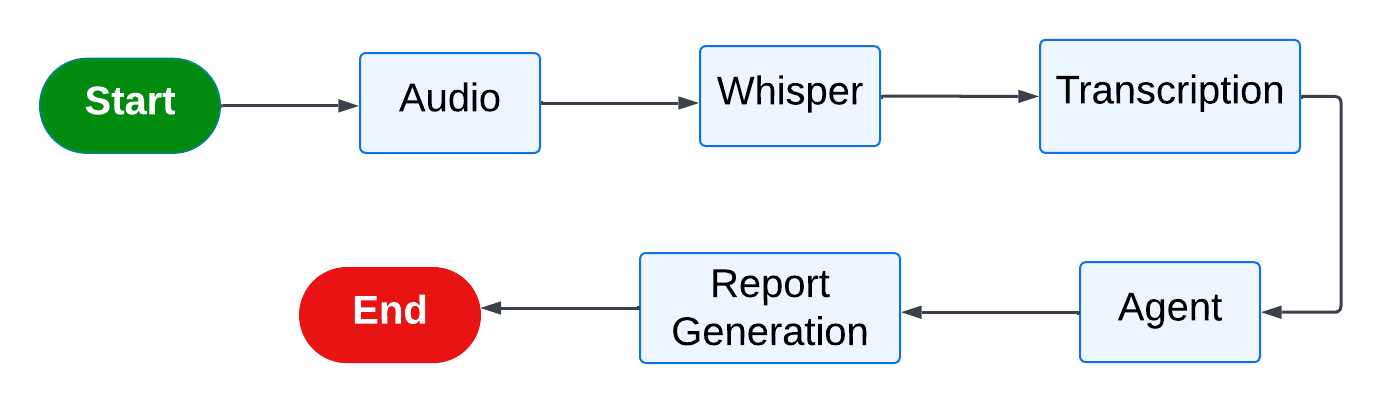

## Conclusion

This tutorial has demonstrated how to build an AI-powered sales call analyzer using LangChain and OpenAI Whisper. By combining audio transcription, NLP analysis, and task automation, we've created an intelligent system capable of generating actionable insights from sales call transcriptions. This system can be extended to include additional analysis tasks, integrations with CRM systems, or customized reporting features, providing businesses with valuable tools to enhance their sales process and customer interactions.
